In [1]:
from Gpt.models import transformer
from Gpt.models.transformer import FrequencyEmbedder
from Gpt.models.transformer import Gpt as Transformer

In [48]:
fe = FrequencyEmbedder(num_frequencies=2, max_freq_log2=1).to("cuda")

In [49]:
import torch

In [58]:
x = torch.ones(1).to("cuda")
x

tensor([1.], device='cuda:0')

In [68]:
fe(torch.pi * x)

tensor([[-8.7423e-08,  1.7485e-07, -1.0000e+00,  1.0000e+00,  3.1416e+00]],
       device='cuda:0')

In [69]:
y = 2 ** torch.linspace(0, 1, 2)
y = torch.pi * y
y = y.to('cuda')

s = torch.sin(y).unsqueeze(-1)
c = torch.cos(y).unsqueeze(-1)
c

z = torch.cat([s, c], dim=-1).view(-1)
z = torch.cat([z, x], dim=-1)
z

tensor([-8.7423e-08, -1.0000e+00,  1.7485e-07,  1.0000e+00,  1.0000e+00],
       device='cuda:0')

In [72]:
print(fe(x))
print(fe(torch.pi * x))
print(z)

tensor([[ 0.8415,  0.9093,  0.5403, -0.4161,  1.0000]], device='cuda:0')
tensor([[-8.7423e-08,  1.7485e-07, -1.0000e+00,  1.0000e+00,  3.1416e+00]],
       device='cuda:0')
tensor([-8.7423e-08, -1.0000e+00,  1.7485e-07,  1.0000e+00,  1.0000e+00],
       device='cuda:0')


In [45]:
torch.sin((2**0)*torch.pi*x), torch.cos((2**0)*torch.pi*x)

(tensor([-8.7423e-08], device='cuda:0'), tensor([-1.], device='cuda:0'))

In [74]:
import torch.nn as nn

In [76]:
class OldFrequencyEmbedder(nn.Module):

    def __init__(self, num_frequencies, max_freq_log2):
        super().__init__()
        frequencies = 2 ** torch.linspace(0, max_freq_log2, steps=num_frequencies)
        self.register_buffer('frequencies', frequencies)

    def forward(self, x):
        # x should be of size (N,) or (N, D)
        N = x.size(0)
        if x.dim() == 1:  # (N,)
            x = x.unsqueeze(1)  # (N, D) where D=1
        x_unsqueezed = x.unsqueeze(-1).to('cuda', torch.float)  # (N, D, 1)  #HARD-CODED TO WORK ONLY WITH GPU
        scaled = self.frequencies.view(1, 1, -1) * x_unsqueezed  # (N, D, num_frequencies)
        s = torch.sin(scaled)
        c = torch.cos(scaled)
        embedded = torch.cat([s, c, x_unsqueezed], dim=-1).view(N, -1)  # (N, D * 2 * num_frequencies + D)
        return embedded

In [275]:
ofe = OldFrequencyEmbedder(128, 14).to("cuda")
ofe(x)

tensor([[ 0.8415,  0.8817,  0.9188,  0.9514,  0.9773,  0.9944,  0.9999,  0.9907,
          0.9632,  0.9138,  0.8385,  0.7339,  0.5972,  0.4272,  0.2250, -0.0045,
         -0.2515, -0.5003, -0.7277, -0.9041, -0.9947, -0.9655, -0.7908, -0.4668,
         -0.0253,  0.4543,  0.8457,  0.9999,  0.8015,  0.2525, -0.4554, -0.9517,
         -0.8596, -0.1185,  0.7641,  0.9339,  0.0535, -0.9282, -0.5731,  0.7433,
          0.6745, -0.8117, -0.3645,  0.9998, -0.5426, -0.2738,  0.8113, -0.9885,
          0.9941, -0.9901,  0.9973, -0.8498,  0.2441,  0.7400, -0.7794, -0.7726,
          0.0915,  0.6008,  0.6761,  0.3422, -0.5432, -0.8781,  0.8632, -0.6287,
          0.8614, -0.8242, -0.8439, -0.6753, -0.9933,  0.0819,  0.1525,  0.7449,
          0.0186,  0.5877,  0.3509,  0.3169, -0.3314,  0.8106, -0.9262, -0.5189,
         -0.7109, -0.4890, -0.9986,  0.6316, -0.4184,  0.9149, -0.9015, -0.9610,
          0.3159, -0.2124,  0.9098, -0.4357, -0.9542,  0.4553,  0.0893,  0.6844,
          0.4540,  0.2743,  

In [182]:
class FrequencyEmbedder(nn.Module):

    def __init__ (self, num_frequencies, max_freq_log2, enable_pi = True, device = "cuda"):
        super().__init__()
        self.device = device
        self.frequencies = 2 ** torch.linspace(0, max_freq_log2, steps=num_frequencies).to(self.device)
        self.enable_pi = enable_pi
    
    def forward (self, x): 
        # x.shape = (N, D) or (N,)
        N = x.size(0)
        if x.dim() == 1:
            x = x.unsqueeze(1)  #x.shape = (N,1) where D=1
        
        if self.enable_pi:
            pix = torch.pi * x  #pix.shape = (N, D)
        else:
            pix = x
        
        pix = pix.unsqueeze(-1).type(torch.float) # pix.shape = (N, D, 1)
        scaled = self.frequencies.view(1, -1, 1) * pix # scaled.shape = (1, num_freq, 1) * (N, D, 1) = (N, num_freq, D)
        s, c = torch.sin(scaled), torch.cos(scaled) # same shapes as scaled.shape

        embedded = torch.cat([s, c], dim=-1).view(N, -1)  # first becomes (N, num_freq, 2 * D) -> (N, 2 * D * num_freq)
        embedded = torch.cat([x, embedded], dim=-1) # (N, D) x (N, 2* D*num_freq) = (N, D + 2 * D * num_freq)
        return embedded

In [260]:
nfe = FrequencyEmbedder(128, 2, True)
nfe.device

'cuda'

In [261]:
nfe_np = FrequencyEmbedder(128, 2, False)
nfe_np.device

'cuda'

In [262]:
x = torch.ones(1).to("cuda") * 1
x

tensor([1.], device='cuda:0')

In [263]:
y = nfe(x)
print(y)
# print(s, c)
# print(s.shape, c.shape, y.shape)

tensor([[ 1.0000e+00, -8.7423e-08, -1.0000e+00, -3.4474e-02, -9.9941e-01,
         -6.9284e-02, -9.9760e-01, -1.0439e-01, -9.9454e-01, -1.3975e-01,
         -9.9019e-01, -1.7532e-01, -9.8451e-01, -2.1104e-01, -9.7748e-01,
         -2.4688e-01, -9.6905e-01, -2.8277e-01, -9.5919e-01, -3.1865e-01,
         -9.4787e-01, -3.5447e-01, -9.3507e-01, -3.9016e-01, -9.2075e-01,
         -4.2565e-01, -9.0489e-01, -4.6088e-01, -8.8746e-01, -4.9577e-01,
         -8.6845e-01, -5.3025e-01, -8.4784e-01, -5.6424e-01, -8.2561e-01,
         -5.9766e-01, -8.0175e-01, -6.3041e-01, -7.7626e-01, -6.6243e-01,
         -7.4913e-01, -6.9360e-01, -7.2036e-01, -7.2385e-01, -6.8995e-01,
         -7.5308e-01, -6.5793e-01, -7.8119e-01, -6.2429e-01, -8.0809e-01,
         -5.8906e-01, -8.3366e-01, -5.5228e-01, -8.5781e-01, -5.1396e-01,
         -8.8044e-01, -4.7415e-01, -9.0145e-01, -4.3289e-01, -9.2071e-01,
         -3.9024e-01, -9.3814e-01, -3.4625e-01, -9.5363e-01, -3.0099e-01,
         -9.6706e-01, -2.5453e-01, -9.

In [264]:
ynp = nfe_np(x)


In [276]:
yofe = ofe(x)
yofe

tensor([[ 0.8415,  0.8817,  0.9188,  0.9514,  0.9773,  0.9944,  0.9999,  0.9907,
          0.9632,  0.9138,  0.8385,  0.7339,  0.5972,  0.4272,  0.2250, -0.0045,
         -0.2515, -0.5003, -0.7277, -0.9041, -0.9947, -0.9655, -0.7908, -0.4668,
         -0.0253,  0.4543,  0.8457,  0.9999,  0.8015,  0.2525, -0.4554, -0.9517,
         -0.8596, -0.1185,  0.7641,  0.9339,  0.0535, -0.9282, -0.5731,  0.7433,
          0.6745, -0.8117, -0.3645,  0.9998, -0.5426, -0.2738,  0.8113, -0.9885,
          0.9941, -0.9901,  0.9973, -0.8498,  0.2441,  0.7400, -0.7794, -0.7726,
          0.0915,  0.6008,  0.6761,  0.3422, -0.5432, -0.8781,  0.8632, -0.6287,
          0.8614, -0.8242, -0.8439, -0.6753, -0.9933,  0.0819,  0.1525,  0.7449,
          0.0186,  0.5877,  0.3509,  0.3169, -0.3314,  0.8106, -0.9262, -0.5189,
         -0.7109, -0.4890, -0.9986,  0.6316, -0.4184,  0.9149, -0.9015, -0.9610,
          0.3159, -0.2124,  0.9098, -0.4357, -0.9542,  0.4553,  0.0893,  0.6844,
          0.4540,  0.2743,  

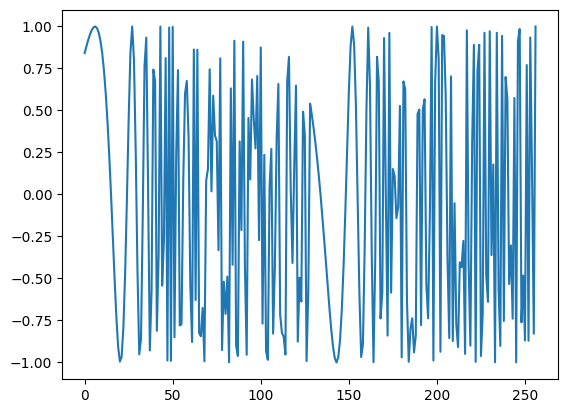

In [277]:
import matplotlib.pyplot as plt

plt.plot(yofe.tolist()[0])

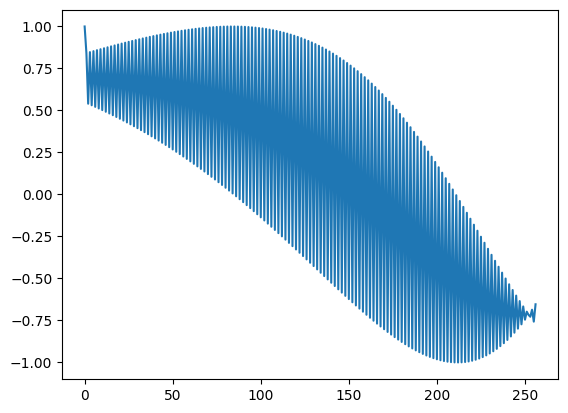

In [273]:
plt.plot(ynp.tolist()[0])

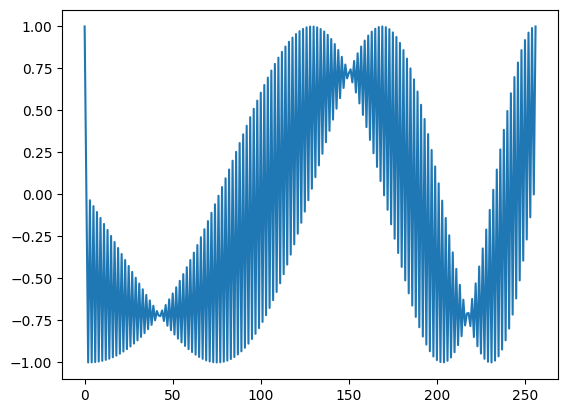

In [274]:
plt.plot(y.tolist()[0])